<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/3-getting-started-with-neural-networks/predicting_house_prices_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting house prices: a regression example

Another common type of
machine-learning problem is regression, which consists of predicting a continuous
value instead of a discrete label: for instance, predicting the temperature tomorrow,
given meteorological data; or predicting the time that a software project will take to
complete, given its specifications.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## The Boston Housing Price dataset

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset we will be using has another interesting difference from our two previous examples: it has very few data points, only 506 in total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, others between 0 and 100...

Let's take a look at the data:

In [2]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
test_targets.shape

(102,)

## Preparing the data

It would be problematic to feed into a neural network values that all take wildly different
ranges. The network might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
to deal with such data is to do feature-wise normalization: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation. This is easily done in Numpy.

In [0]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the
training data. You should never use in your workflow any quantity computed on the
test data, even for something as simple as data normalization.

## Building your network

In general, the less training data you have, the worse overfitting
will be, and using a small network is one way to mitigate overfitting.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))

  model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])

  return model

This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). 

Applying an activation function would constrain the range that the output can take; for instance if we applied a sigmoid activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the mse loss function -- Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: mae. This stands for Mean Absolute Error. It is simply the absolute value of the difference between the predictions and the targets.

## Validating your approach using K-fold validation

A consequence is that our validation scores may change a lot depending on which data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a high variance with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the K validation scores obtained.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/kfold-cross-validation.PNG?raw=1' width='800'/>

In [10]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print(f'processing fold #{str(i)}')

  # Prepare the validation data: data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  # Prepare the training data: data from all other partitions
  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

  # Build the Keras model (already compiled)
  model = build_model()
  # Train the model (in silent mode, verbose=0)
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  # Evaluate the model on the validation data
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


Running this with num_epochs = 100 yields the following results:

In [11]:
all_scores

[1.9265903, 2.5938854, 2.6897266, 2.3861775]

In [12]:
np.mean(all_scores)

2.399095

Let's try training the network for a bit longer: 500 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop to save the per-epoch validation score log:

In [0]:
from tensorflow.keras import backend

backend.clear_session()

In [20]:
num_epochs = 500
all_mae_histories  = []

for i in range(k):
  print(f'processing fold #{str(i)}')

  # Prepare the validation data: data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  # Prepare the training data: data from all other partitions
  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

  # Build the Keras model (already compiled)
  model = build_model()
  # Train the model (in silent mode, verbose=0)
  history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  # Evaluate the model on the validation data


processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [29]:
for key, value in history.history.items():
  print(f'key : {str(key)}')

mae_history = history.history['mae']
all_mae_histories.append(mae_history)

key : loss
key : mae


We can then compute the average of the per-epoch MAE scores for all folds:

In [0]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plotting validation scores

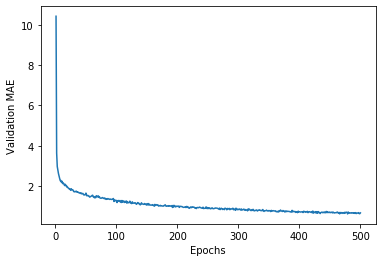

In [28]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's:

* Omit the first 10 data points, which are on a different scale from the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

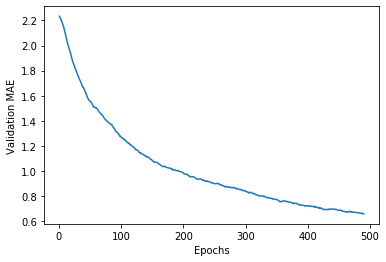

In [30]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

Once we are done tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [0]:
# Get a fresh, compiled model.
model = build_model()

# Train it on the entirety of the data.
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=0)

In [33]:
test_mae_score

2.7094011

In [34]:
test_mse_score

17.53174695781633

## Wrapping up

Here's what you should take away from this example:

* Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
* When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.

This example concludes our series of three introductory practical examples. You are now able to handle common types of problems with vector data input:

* Binary (2-class) classification.
* Multi-class, single-label classification.
* Scalar regression.